<a href="https://colab.research.google.com/github/souhirbenamor/EPF/blob/main/DNN_flexible_june24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_excel("/Users/vaughan/Desktop/MEF_2020_Real_data.xlsx")

# Remove duplicate dates
data.drop(data.loc[data['Date'].duplicated()].index, inplace=True)

# Set 'Date' as the index and drop the 'Date' column
data.set_index(data['Date'], inplace=True)
data.drop(columns=['Date'], inplace=True)

# Display the last few rows of the data
print("Tail of the data:")
print(data.tail())

# Check for missing values
missing_rows = data[data.isna().any(axis=1)].tail()
cols_with_missing = data.columns[data.isna().any()].tolist()

# Prepare and print text results for missing values
if missing_rows.empty:
    result_text = "No rows with missing values found."
else:
    result_text = f"Rows with missing values:\n{missing_rows.to_string(index=False)}"

if not cols_with_missing:
    result_text += "\n\nNo columns with missing values."
else:
    result_text += f"\n\nColumns with missing values: {', '.join(cols_with_missing)}"

print(result_text)

# Handle negative values in 'Generation'
num_neg_values = (data['Generation'] < 0).sum()
data.loc[data['Generation'] < 0, 'Generation'] = 0

# Handle zero values in 'Generation' by setting corresponding 'Emissions' to zero
num_zero_generation = (data['Generation'] == 0).sum()
data.loc[data['Generation'] == 0, 'Emissions'] = 0

# Display the results of handling negative and zero values
print(f"Negative values in Generation: {'Yes' if num_neg_values > 0 else 'No'}")
print(f"Number of negative values converted to zero: {num_neg_values}")
print(f"Number of zero values in Generation: {num_zero_generation}")
print(f"Number of Emissions converted to zero: {num_zero_generation}")

# Calculate the first difference of the time series
ret = data - data.shift(1)
ret = ret[1:]  # Eliminate the first row which will be NaN

# Display the differenced data
print("First difference of the data:")
print(ret)

# Standardize the 'Generation' and 'Emissions' columns
scaler = StandardScaler()
ret[['Generation', 'Emissions']] = scaler.fit_transform(ret[['Generation', 'Emissions']])

# Display the standardized data
print("Standardized data:")
print(ret)

# Check for missing values in the standardized data
missing_rows_ret = ret[ret.isna().any(axis=1)].tail()
cols_with_missing_ret = ret.columns[ret.isna().any()].tolist()

# Prepare and print text results for missing values in the standardized data
if missing_rows_ret.empty:
    result_text_ret = "No rows with missing values found."
else:
    result_text_ret = f"Rows with missing values:\n{missing_rows_ret.to_string(index=False)}"

if not cols_with_missing_ret:
    result_text_ret += "\n\nNo columns with missing values."
else:
    result_text_ret += f"\n\nColumns with missing values: {', '.join(cols_with_missing_ret)}"

print(result_text_ret)

Tail of the data:
                     Emissions  Generation
Date                                      
2020-12-31 19:00:00     45.963    26847000
2020-12-31 20:00:00    466.896    19355000
2020-12-31 21:00:00    474.238    39929000
2020-12-31 22:00:00    483.229    31848000
2020-12-31 23:00:00    480.391    38142000
No rows with missing values found.

No columns with missing values.
Negative values in Generation: No
Number of negative values converted to zero: 0
Number of zero values in Generation: 0
Number of Emissions converted to zero: 0
First difference of the data:
                     Emissions  Generation
Date                                      
2020-01-01 01:00:00    -13.329   -441000.0
2020-01-01 02:00:00   -364.852   -230000.0
2020-01-01 03:00:00    366.733  -7034000.0
2020-01-01 04:00:00     -0.763      1000.0
2020-01-01 05:00:00      3.897   7303000.0
...                        ...         ...
2020-12-31 19:00:00   -400.084    168000.0
2020-12-31 20:00:00    420.933  -74

In [4]:
ret

,Emissions,Generation
Date,,
2020-01-01 01:00:00,-0.096187,-0.061957
2020-01-01 02:00:00,-2.631565,-0.032356
2020-01-01 03:00:00,2.645030,-0.986890
2020-01-01 04:00:00,-0.005554,0.000051
2020-01-01 05:00:00,0.028057,1.024449
...,...,...
2020-12-31 19:00:00,-2.885677,0.023479
2020-12-31 20:00:00,3.035950,-1.051143
2020-12-31 21:00:00,0.052904,2.886238


Dynamic Linear Regression Model

Linear Regression results saved to 'linear_regression_results.xlsx'.


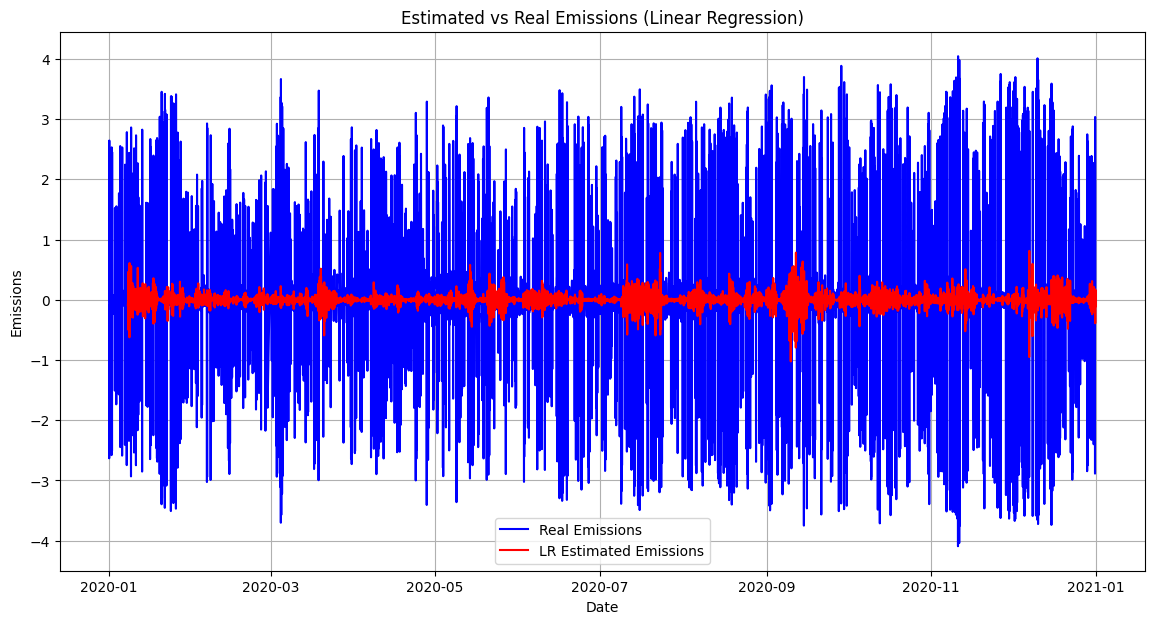

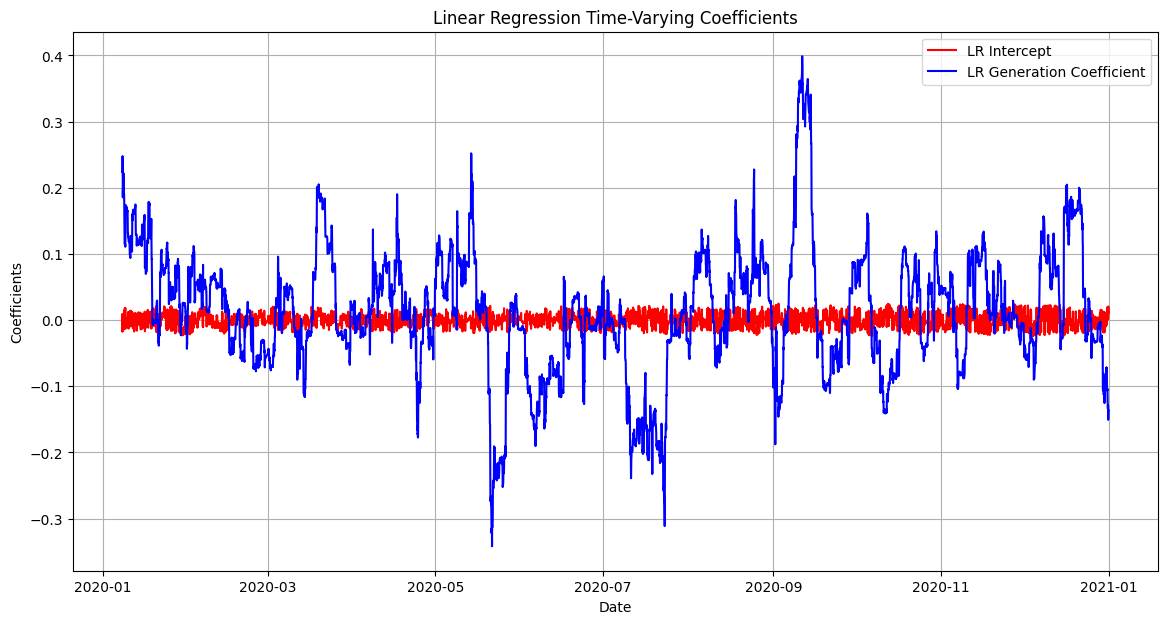

Linear Regression results and plots generated.


In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming 'ret' DataFrame is prepared with required columns

# Prepare DataFrames to store the time-varying coefficients and estimated emissions
lr_coefficients = pd.DataFrame(index=ret.index, columns=['LR_Intercept', 'LR_Generation'])
estimated_emissions_lr = []

window_length = 168

for i in range(len(ret) - window_length + 1):
    ret_window = ret.iloc[i:i + window_length]
    
    # Fit Linear Regression model
    lr_model = LinearRegression()
    lr_model.fit(ret_window[['Generation']], ret_window['Emissions'])
    
    # Predict emissions
    forecast = lr_model.predict(ret_window[['Generation']].iloc[-1:])
    estimated_emissions_lr.append(forecast[0])
    
    # Store coefficients
    intercept, generation_coeff = lr_model.intercept_, lr_model.coef_[0]
    lr_coefficients.loc[ret.index[i + window_length - 1]] = [intercept, generation_coeff]

results_lr = pd.DataFrame(index=ret.index)
results_lr['LR_Estimated_Emission'] = pd.Series(estimated_emissions_lr, index=ret.index[window_length - 1:])
coefficients_lr = lr_coefficients.dropna()

# Save results to Excel for Linear Regression
with pd.ExcelWriter('linear_regression_results.xlsx') as writer:
    pd.DataFrame({
        'Actual_Emissions': ret['Emissions'],
        'LR_Estimated_Emission': results_lr['LR_Estimated_Emission']
    }).to_excel(writer, sheet_name='Estimated_Emissions')
    
    coefficients_lr.to_excel(writer, sheet_name='Time_Varying_Coefficients')

print("Linear Regression results saved to 'linear_regression_results.xlsx'.")

# Plotting the estimated vs real emissions for Linear Regression
plt.figure(figsize=(14, 7))
plt.plot(ret.index, ret['Emissions'], label='Real Emissions', color='blue')
plt.plot(results_lr.index, results_lr['LR_Estimated_Emission'], label='LR Estimated Emissions', color='red')
plt.xlabel('Date')
plt.ylabel('Emissions')
plt.title('Estimated vs Real Emissions (Linear Regression)')
plt.legend()
plt.grid(True)
plt.savefig('lr_estimated_vs_real_emissions.png')
plt.show()

# Plotting the time-varying coefficients for Linear Regression
plt.figure(figsize=(14, 7))
plt.plot(coefficients_lr.index, coefficients_lr['LR_Intercept'], label='LR Intercept', color='red')
plt.plot(coefficients_lr.index, coefficients_lr['LR_Generation'], label='LR Generation Coefficient', color='blue')
plt.title('Linear Regression Time-Varying Coefficients')
plt.xlabel('Date')
plt.ylabel('Coefficients')
plt.legend()
plt.grid(True)
plt.savefig('lr_time_varying_coefficients.png')
plt.show()

print("Linear Regression results and plots generated.")


Markov Switching Dynamic Regression Model MSDR 

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid
import statsmodels.api as sm
from joblib import Parallel, delayed

# Define the hyperparameter grid and regularization options
param_grid = {
    'k_regimes': [2, 3],
    'switching_variance': [True, False],
    'trend': ['c', 't'],
    'exog': [ret[['Generation']], None],
    'regularization': [None, 'l1', 'l2'],
    'penalty': [0.01, 0.1, 1.0]
}

# Function to fit the model and evaluate it
def fit_markov_model(ret_window, params):
    try:
        # Add regularization if specified
        if params['regularization'] == 'l1':
            msdr_model = sm.tsa.MarkovRegression(
                endog=ret_window['Emissions'],
                k_regimes=params['k_regimes'],
                trend=params['trend'],
                exog=params['exog'],
                switching_variance=params['switching_variance'],
                penalty=params['penalty'],
                regularization='l1'
            )
        elif params['regularization'] == 'l2':
            msdr_model = sm.tsa.MarkovRegression(
                endog=ret_window['Emissions'],
                k_regimes=params['k_regimes'],
                trend=params['trend'],
                exog=params['exog'],
                switching_variance=params['switching_variance'],
                penalty=params['penalty'],
                regularization='l2'
            )
        else:
            msdr_model = sm.tsa.MarkovRegression(
                endog=ret_window['Emissions'],
                k_regimes=params['k_regimes'],
                trend=params['trend'],
                exog=params['exog'],
                switching_variance=params['switching_variance']
            )
        
        msdr_results = msdr_model.fit(disp=False)
        
        # Calculate MAE
        forecast = msdr_results.predict(start=ret_window.index[1], end=ret_window.index[-1])
        mae = np.mean(np.abs(ret_window['Emissions'][1:] - forecast))

        return msdr_results, msdr_results.aic, mae
    except Exception as e:
        print(f"Model fitting failed for parameters: {params} with error: {e}")
        return None, np.inf, np.inf

# Implement the rolling window approach with parallel processing
window_length = 168
results = []  # To store the results for each rolling window

def process_window(i):
    ret_window = ret.iloc[i:i + window_length]
    best_result = None
    best_aic = np.inf
    best_mae = np.inf
    
    for params in ParameterGrid(param_grid):
        result, aic, mae = fit_markov_model(ret_window, params)
        if mae < best_mae:
            best_result = result
            best_aic = aic
            best_mae = mae
    
    return best_result

results = Parallel(n_jobs=-1)(delayed(process_window)(i) for i in range(len(ret) - window_length + 1))

# Estimate the emission time series using the best model for each window
estimated_ret = ret[['Emissions']].copy()
estimated_ret['Estimated_Emission'] = np.nan

for i in range(len(ret) - window_length + 1):
    ret_window = ret.iloc[i:i + window_length]
    msdr_results = results[i]

    if msdr_results is not None:
        # Forecast the emission time series using the model results
        forecast = msdr_results.predict(start=ret_window.index[-1], end=ret_window.index[-1])
        estimated_ret.loc[ret_window.index[-1], 'Estimated_Emission'] = forecast[0]
    else:
        print(f"No results for window ending on {ret_window.index[-1]}")

# Save the estimated emission to an Excel file
estimated_ret.to_excel('estimated_emission_enhanced.xlsx', index=True)

# Verify the estimated emissions column
print("Estimated Emissions:")
print(estimated_ret['Estimated_Emission'].dropna().head())

# Save time-varying coefficients in Excel file
coefficients_ret = pd.DataFrame(columns=['Intercept', 'Generation_regime1', 'Generation_regime2', 'Generation_regime3'])
for i in range(len(ret) - window_length + 1):
    msdr_results = results[i]
    if msdr_results is not None:
        params = msdr_results.params
        coefficients_ret.loc[ret.index[i + window_length - 1]] = [params[0], params[1], params[2], params[3]]

# Save the time-varying coefficients to an Excel file
coefficients_ret.to_excel('time_varying_coefficients_enhanced.xlsx', index=True)

# Plot the estimated and original emission time series
plt.figure(figsize=(12, 6))
plt.plot(estimated_ret.index, estimated_ret['Estimated_Emission'], label='Estimated Emission', color='red')
plt.plot(ret.index, ret['Emissions'], label='Original Emission', color='blue')
plt.xlabel('Date')
plt.ylabel('Emission')
plt.legend()
plt.title('Estimated vs. Original Emission Time Series')
plt.grid(True)
plt.savefig('emission_comparison_enhanced.png')
plt.show()


In [ ]:
# Assuming 'results' contains the best model for each window
# And 'ret' is the original DataFrame containing the emissions data

# Create DataFrames to store coefficients and combined coefficients
coefficients_ret = pd.DataFrame(columns=['Intercept', 'Generation_regime1', 'Generation_regime2', 'Generation_regime3'])
combined_coefficients_ret = pd.DataFrame(columns=['Intercept', 'Generation_combined'])

for i in range(len(ret) - window_length + 1):
    msdr_results = results[i]
    if msdr_results is not None:
        params = msdr_results.params
        intercept = params[0]
        
        # Initialize coefficients for all regimes
        generation_coeff_regime1 = generation_coeff_regime2 = generation_coeff_regime3 = 0

        # Check if there are parameters for the second and third regime
        if len(params) > 1:
            generation_coeff_regime1 = params[1]
        if len(params) > 2:
            generation_coeff_regime2 = params[2]
        if len(params) > 3:
            generation_coeff_regime3 = params[3]

        # Store individual regime coefficients
        coefficients_ret.loc[ret.index[i + window_length - 1]] = [
            intercept, generation_coeff_regime1, generation_coeff_regime2, generation_coeff_regime3]

        # Get the smoothed probabilities of being in each regime for the last observation in the window
        probabilities = msdr_results.smoothed_marginal_probabilities.iloc[-1]

        # Calculate the combined coefficient for the 'Generation' variable using the smoothed probabilities
        combined_generation_coeff = (
            probabilities[0] * generation_coeff_regime1 +
            probabilities[1] * generation_coeff_regime2 +
            probabilities.get(2, 0) * generation_coeff_regime3  # Use get to handle fewer regimes
        )

        # Store the combined coefficients
        combined_coefficients_ret.loc[ret.index[i + window_length - 1]] = [intercept, combined_generation_coeff]

# Save the individual regime coefficients and combined coefficients to Excel files
coefficients_ret.to_excel('time_varying_coefficients_enhanced.xlsx', index=True)
combined_coefficients_ret.to_excel('combined_time_varying_coefficients_enhanced.xlsx', index=True)

# Plot combined time-varying coefficients for 'Generation' variable
plt.figure(figsize=(12, 6))
plt.plot(combined_coefficients_ret.index, combined_coefficients_ret['Intercept'], label='Intercept', color='green')
plt.plot(combined_coefficients_ret.index, combined_coefficients_ret['Generation_combined'], label='Generation Combined', color='blue')
plt.xlabel('Date')
plt.ylabel('Coefficients')
plt.legend()
plt.title('Combined Time-Varying Coefficients for Generation')
plt.grid(True)
plt.savefig('combined_time_varying_coefficients_enhanced.png')
plt.show()


C:\Users\Gams_Benamor\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Gams_Benamor\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                        Markov Switching Model Results                        
Dep. Variable:              Emissions   No. Observations:                 8759
Model:               MarkovRegression   Log Likelihood               -4807.780
Date:                Tue, 23 Jul 2024   AIC                           9645.559
Time:                        12:24:48   BIC                           9751.727
Sample:                             0   HQIC                          9681.734
                               - 8759                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.279      0.201      -0.001       0.007
x1             0.0065      0.003      2.507      0.0

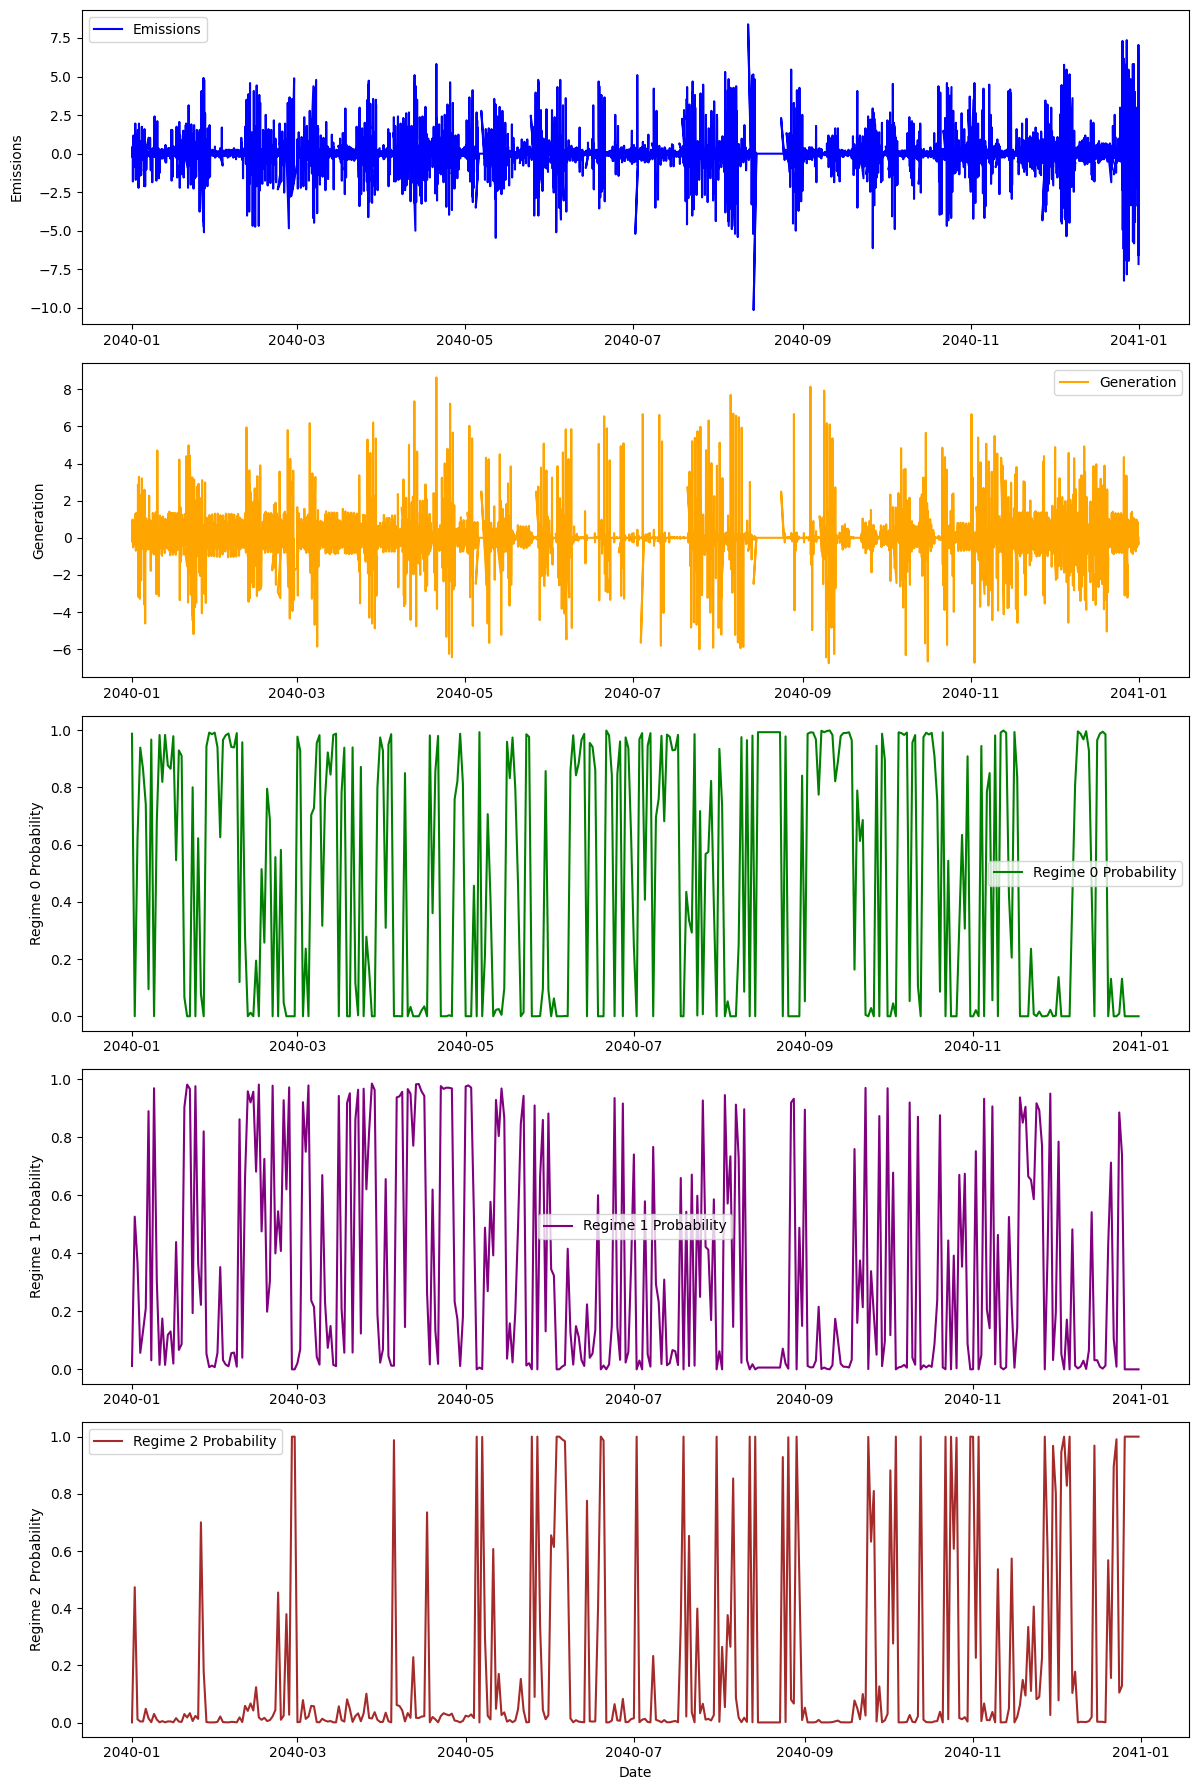

In [10]:
# Fit the Markov switching model to 'Emissions' data for plotting probabilities
msdr_model = sm.tsa.MarkovRegression(
    endog=ret['Emissions'],
    k_regimes=3,
    trend='c',
    exog=ret['Generation'],  # Using 'Generation' as an exogenous variable
    switching_variance=True
)
msdr_model_results = msdr_model.fit()

# Print the full summary of the results
summary_text = msdr_model_results.summary().as_text()
print(summary_text)

# Resample the probabilities to daily frequency
daily_probs = msdr_model_results.smoothed_marginal_probabilities.resample('D').ffill()

# Plot the Emissions, Generation, and probabilities in separate plots
figure, axes = plt.subplots(5, 1, figsize=(12, 18))

# Plot Emissions data
axes[0].plot(ret.index, ret['Emissions'], label='Emissions', color='blue')
axes[0].set_ylabel('Emissions')
axes[0].legend()

# Plot Generation data
axes[1].plot(ret.index, ret['Generation'], label='Generation', color='orange')
axes[1].set_ylabel('Generation')
axes[1].legend()

# Plot Smoothed probability of regime 0
axes[2].plot(daily_probs.index, daily_probs[0], label='Regime 0 Probability', color='green')
axes[2].set_ylabel('Regime 0 Probability')
axes[2].legend()

# Plot Smoothed probability of regime 1
axes[3].plot(daily_probs.index, daily_probs[1], label='Regime 1 Probability', color='purple')
axes[3].set_ylabel('Regime 1 Probability')
axes[3].legend()

# Plot Smoothed probability of regime 2
axes[4].plot(daily_probs.index, daily_probs[2], label='Regime 2 Probability', color='brown')
axes[4].set_ylabel('Regime 2 Probability')
axes[4].legend()

plt.xlabel('Date')
plt.tight_layout()
plt.show()

In [11]:
# Assuming msdr_model_results is your fitted model object
summary_text = msdr_model_results.summary().as_text()

# Specify the file path where you want to save the summary
file_path = 'model_summary.txt'

# Save the summary to the text file
with open(file_path, 'w') as file:
    file.write(summary_text)

print(f"Summary saved to {file_path}")
summary_text = msdr_model_results.summary().as_text()
print(summary_text)

Summary saved to model_summary.txt
                        Markov Switching Model Results                        
Dep. Variable:              Emissions   No. Observations:                 8759
Model:               MarkovRegression   Log Likelihood               -4807.780
Date:                Tue, 23 Jul 2024   AIC                           9645.559
Time:                        12:25:23   BIC                           9751.727
Sample:                             0   HQIC                          9681.734
                               - 8759                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0026      0.002      1.279      0.201      -0.001       0.007
x1             0.

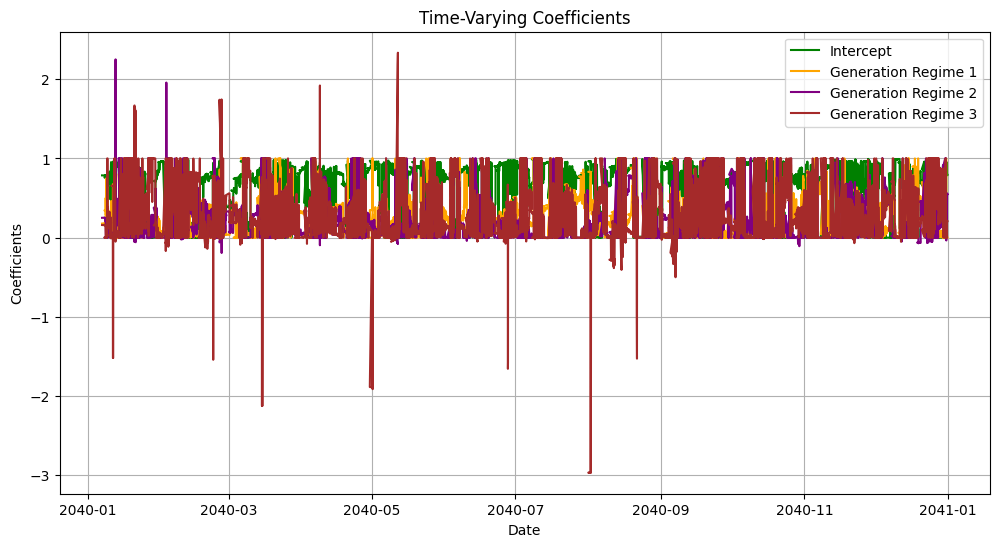

In [12]:
# Plot time-varying coefficients
plt.figure(figsize=(12, 6))
plt.plot(coefficients_ret.index, coefficients_ret['Intercept'], label='Intercept', color='green')
plt.plot(coefficients_ret.index, coefficients_ret['Generation_regime1'], label='Generation Regime 1', color='orange')
plt.plot(coefficients_ret.index, coefficients_ret['Generation_regime2'], label='Generation Regime 2', color='purple')
plt.plot(coefficients_ret.index, coefficients_ret['Generation_regime3'], label='Generation Regime 3', color='brown')
plt.xlabel('Date')
plt.ylabel('Coefficients')
plt.legend()
plt.title('Time-Varying Coefficients')
plt.grid(True)
plt.savefig('time_varying_coefficients.png')
plt.show()